In [19]:
import torch
import torch.nn as nn

class SimCLRLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, z_i, z_j):
        # TODO: implement SimCLR's Contrastive Loss
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        # Cosine similarity between normalized embeddings
        similarity_matrix = torch.matmul(z_i, z_j.T) / self.temperature
        print(similarity_matrix.shape)
        # Calculate positive and negative pairs
        batch_size = z_i.size(0)
        positive_mask = torch.eye(batch_size, dtype=torch.bool, device=z_i.device)
        print(positive_mask)
        negative_mask = ~positive_mask
        print(negative_mask)
        
        # Compute loss
        positive_pairs = similarity_matrix[positive_mask].view(batch_size, -1)
        negative_pairs = similarity_matrix[negative_mask].view(batch_size, -1)
        print(similarity_matrix)
        print(positive_pairs)
        print(negative_pairs)
        # Calculate logits and labels
        logits = torch.cat([positive_pairs, negative_pairs], dim=1)
        print(logits)
        labels = torch.zeros(batch_size, device=z_i.device, dtype=torch.long)
        print(labels)
        # Calculate cross-entropy loss
        loss = nn.functional.cross_entropy(logits, labels)
        print(loss)
        return loss

In [20]:
z_i = torch.rand(4, 320)
z_j = torch.rand(4, 320)
fn = SimCLRLoss(0.5)

loss = fn(z_i, z_j)

torch.Size([4, 4])
tensor([[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]])
tensor([[False,  True,  True,  True],
        [ True, False,  True,  True],
        [ True,  True, False,  True],
        [ True,  True,  True, False]])
tensor([[1.5625, 1.5068, 1.5054, 1.4919],
        [1.5522, 1.5231, 1.5135, 1.4572],
        [1.5336, 1.5252, 1.4593, 1.5100],
        [1.5241, 1.4731, 1.5171, 1.4957]])
tensor([[1.5625],
        [1.5231],
        [1.4593],
        [1.4957]])
tensor([[1.5068, 1.5054, 1.4919],
        [1.5522, 1.5135, 1.4572],
        [1.5336, 1.5252, 1.5100],
        [1.5241, 1.4731, 1.5171]])
tensor([[1.5625, 1.5068, 1.5054, 1.4919],
        [1.5231, 1.5522, 1.5135, 1.4572],
        [1.4593, 1.5336, 1.5252, 1.5100],
        [1.4957, 1.5241, 1.4731, 1.5171]])
tensor([0, 0, 0, 0])
tensor(1.3860)


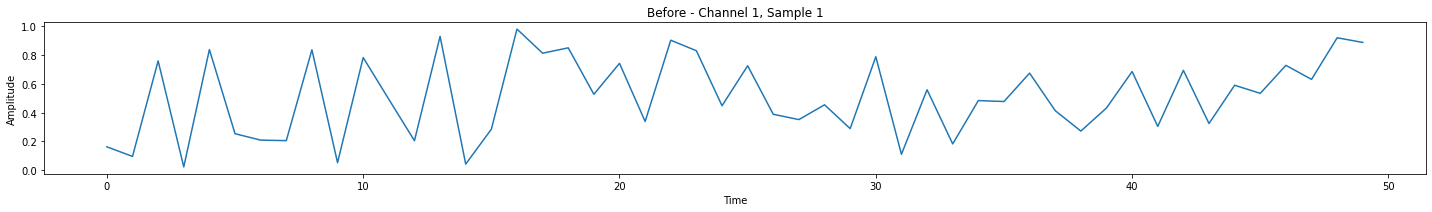

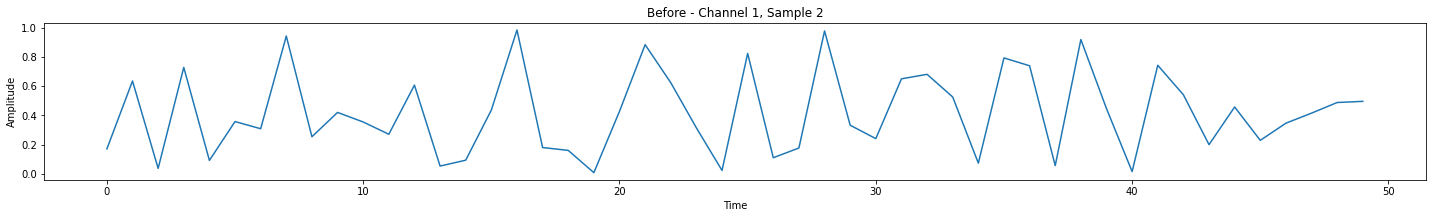

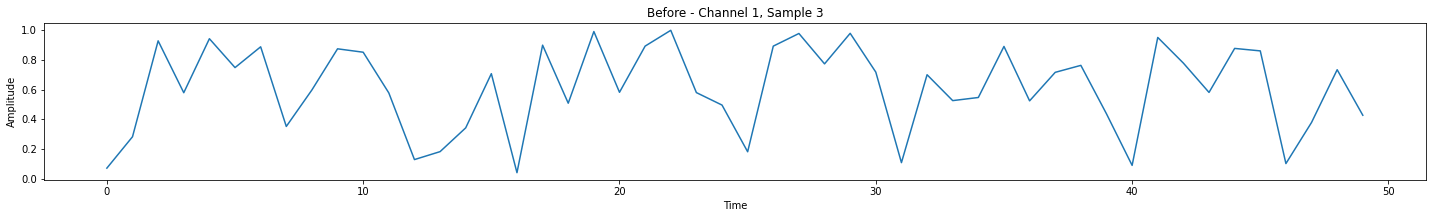

(1, 1, 100)


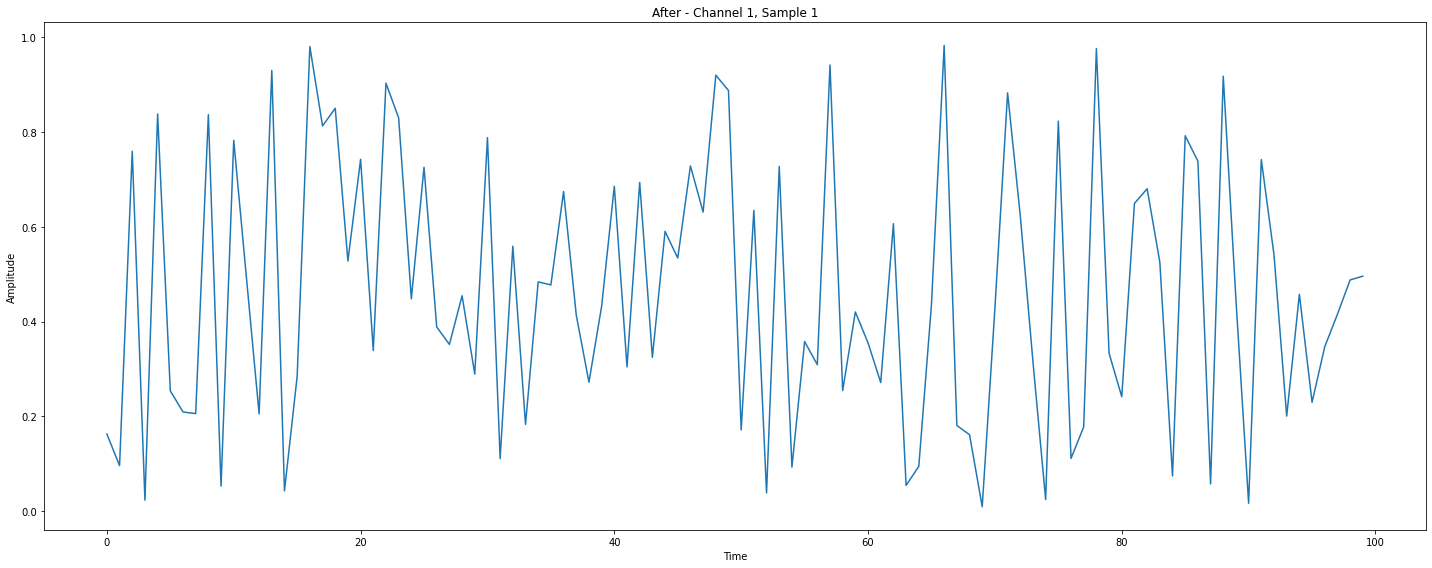

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def concatenate_adjacent(data):
    num_samples, num_channels, num_data_points = data.shape
    new_data = np.zeros((num_samples // 2, num_channels, num_data_points * 2))

    for idx in range(num_samples // 2):
        new_data[idx, :, :num_data_points] = data[2 * idx, :, :]
        new_data[idx, :, num_data_points:] = data[2 * idx + 1, :, :]
    return new_data
def plot_time_series(data, title):
    num_samples, num_channels, _ = data.shape
    for i in range(num_samples):
        plt.figure(figsize=(20, 8))
        for j in range(num_channels):
            plt.subplot(num_samples, num_channels, i * num_channels + j + 1) 
            plt.plot(data[i, j])
            plt.title(f"{title} - Channel {j+1}, Sample {i+1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
# 가상의 데이터 생성 (N, 12, 2500)
num_samples = 3  # 예시로 10개의 샘플을 가정
num_channels = 1
num_data_points = 50
data = np.random.rand(num_samples, num_channels, num_data_points)
plot_time_series(data, 'Before')

# 인접한 두 데이터 이어붙이기
concatenated_data = concatenate_adjacent(data)
print(concatenated_data.shape)  # (N//2, 12, 5000)
plot_time_series(concatenated_data, 'After')

In [ ]:
"""
Created on Thu Aug 21 2023
@author: Kichang Lee
@contact: kichan.lee@yonsei.ac.kr
"""
import os
import time
import numpy as np
import pandas as pd 
from tqdm import tqdm
import multiprocessing
from scipy.signal import resample
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

'''
_s_list.csv: TMT stage info
_s_*.csv   : csv file contains TMT stage data   (5000, 12) | 500Hz
_full.csv  : csv file contains Full TMT data    (N, 12) | 200Hz -> each patient have different N

# of patient : 16232
# of patient with CAD: 1632
'''
DATAPATH = f'../dr-you-ecg-20220420_mount/DachungBoo_TMT/dhkim2'
SAVEPATH = f'./dataset/TMT_labeled_Whole'
os.makedirs(SAVEPATH, exist_ok=True)

def process_file(files):
    source_sr, target_sr = 500, 250  # for snapshot 500Hz / for full 200Hz -> 250 Hz
    file_name = files[0]
    target = int(files[1])
    df = pd.read_csv(f'{DATAPATH}/{file_name}')
    data = df.to_numpy()
    data = resample_data(data, source_sr, target_sr)
    return data, target

def resample_data(data, original_rate, target_rate):
    original_length = data.shape[0]
    target_length = int(original_length * target_rate / original_rate)
    resampled_data = resample(data, target_length)
    return resampled_data

if __name__ == '__main__':
    database = pd.read_csv(f'../dr-you-ecg-20220420_mount/DachungBoo_TMT/20230821_TMT_WHOLE_DATA.csv', encoding='cp949')
    database['CAD_OUTCOME'] = database['CAD_OUTCOME'].fillna(0)
    fnames = [name.split('/')[-1] for name in database['fname'].to_list()]
    labels = [int(label) for label in database['CAD_OUTCOME'].to_list()]
    train_files, val_files, train_labels, val_labels = train_test_split(fnames, labels, test_size=0.2, random_state=42)
    train_counts = [train_labels.count(i) for i in range(2)]
    val_counts   = [  val_labels.count(i) for i in range(2)]
    print(sum(train_counts), train_counts[0], train_counts[1], train_counts[0]/sum(train_counts), train_counts[1]/sum(train_counts))
    print(  sum(val_counts),   val_counts[0],   val_counts[1],     val_counts[0]/sum(val_counts),     val_counts[1]/sum(val_counts))
    print(sum(train_counts)/(sum(train_counts)+sum(val_counts)))

    #desired_stages = [f'STAGE {i+1}' for i in range(4)]
    
    desired_stages = ['STAGE 1',
                      'STAGE 2',
                      'STAGE 3',
                      'STAGE 4',
                      'SITTING',
                      '#1',
                      '#2',
                      '#3',
                      ]
    
    train_file_dict  = defaultdict(list)
    train_label_dict = defaultdict(list)
    # train_files = train_files[:1000]
    # val_files = val_files[:50]
    '''
    Train Set
    '''
    for idx, f in enumerate(tqdm(train_files)):
        if not os.path.exists(f"{DATAPATH}/{f}_s_list.csv"):
            print(f"*** {f} DOESN'T HAVE STAGE INFORMATION! ***", flush=True)
            
        else:
            df = pd.read_csv(f"{DATAPATH}/{f}_s_list.csv")
            for jdx in range(len(df)):
                stage      = df.loc[jdx]['StageName']
                stripIndex = df.loc[jdx]['StripIndex']
                if isinstance(stage, str) and 'STAGE' in stage:
                    train_file_dict[ 'all'].append(f'{f}_s_i{stripIndex}.csv')
                    train_label_dict['all'].append(train_labels[idx])
                    
                if isinstance(stage, str) and '#' in stage:
                    train_file_dict[ 'STAGEresting'].append(f'{f}_s_i{stripIndex}.csv')
                    train_label_dict['STAGEresting'].append(train_labels[idx])
                    
                for stage_ in desired_stages:
                    if isinstance(stage, str) and stage_ in stage:
                        key_name = f'STAGE{stage_}' if ('#' in stage_ or stage_=='SITTING') else stage_
                        train_file_dict[ key_name].append(f'{f}_s_i{stripIndex}.csv')
                        train_label_dict[key_name].append(train_labels[idx])
                    
                    # if isinstance(stage, str) and 'STAGE' in stage:
                    #     train_file_dict[ 'all'].append(f'{f}_s_i{stripIndex}.csv')
                    #     train_label_dict['all'].append(train_labels[idx])
                    
                    # if isinstance(stage, str) and '#' in stage:
                    #     train_file_dict[ 'STAGEresting'].append(f'{f}_s_i{stripIndex}.csv')
                    #     train_label_dict['STAGEresting'].append(train_labels[idx])
    
    test_file_dict  = defaultdict(list)
    test_label_dict = defaultdict(list)

    '''
    Test Set
    '''
    for idx, f in enumerate(tqdm(val_files)):
        if not os.path.exists(f"{DATAPATH}/{f}_s_list.csv"):
            print(f"*** {f} DOESN'T HAVE STAGE INFORMATION! ***", flush=True)
            
        else:
            df = pd.read_csv(f"{DATAPATH}/{f}_s_list.csv")
            for jdx in range(len(df)):
                stage      = df.loc[jdx]['StageName']
                stripIndex = df.loc[jdx]['StripIndex']
                
                if isinstance(stage, str) and 'STAGE' in stage:
                    test_file_dict[ 'all'].append(f'{f}_s_i{stripIndex}.csv')
                    test_label_dict['all'].append(train_labels[idx])
                    
                if isinstance(stage, str) and '#' in stage:
                    test_file_dict[ 'STAGEresting'].append(f'{f}_s_i{stripIndex}.csv')
                    test_label_dict['STAGEresting'].append(train_labels[idx])
                        
                for stage_ in desired_stages:
                    if isinstance(stage, str) and stage_ in stage:
                        key_name = f'STAGE{stage_}' if ('#' in stage_ or stage_=='SITTING') else stage_
                        test_file_dict[ key_name].append(f'{f}_s_i{stripIndex}.csv')
                        test_label_dict[key_name].append(train_labels[idx])
                    
    num_processes = multiprocessing.cpu_count()
    
    for stage in train_file_dict.keys():
        if stage != 'all':
            train_set = np.array([train_file_dict[stage], train_label_dict[stage]]).transpose(1,0)
            datas, targets = [], []
            with multiprocessing.Pool(processes=num_processes) as pool:
                results = list(tqdm(pool.imap(process_file, train_set), total=len(train_set)))
            for data, target in results:
                datas.append(data)
                targets.append(target)
            
            os.makedirs(SAVEPATH, exist_ok=True)
            np.savez_compressed(f"{SAVEPATH}/{stage.replace(' ', '')}_train.npz", data=np.array(datas), target=np.array(targets))
            # np.save(f"{SAVEPATH}/{stage.replace(' ', '')}_X_train.npy", np.array(datas))
            # np.save(f"{SAVEPATH}/{stage.replace(' ', '')}_Y_train.npy", np.array(targets))
            print(f"{stage} trainset {np.shape(datas)} saved!")
            
            test_set = np.array([test_file_dict[stage], test_label_dict[stage]]).transpose(1,0)
            datas, targets = [], []
            with multiprocessing.Pool(processes=num_processes) as pool:
                results = list(tqdm(pool.imap(process_file, test_set), total=len(test_set)))
            
            for data, target in results:
                datas.append(data)
                targets.append(target)
            
            os.makedirs(SAVEPATH, exist_ok=True)
            np.savez_compressed(f"{SAVEPATH}/{stage.replace(' ', '')}_test.npz", data=np.array(datas), target=np.array(targets))
            # np.save(f"{SAVEPATH}/{stage.replace(' ', '')}_X_test.npy", np.array(datas))
            # np.save(f"{SAVEPATH}/{stage.replace(' ', '')}_Y_test.npy", np.array(targets))
            print(f"{stage} testset {np.shape(datas)} saved!")
        else:
            pass
            #TODO: ALL data 관련해서 학습데이터셋 정리!!
            #TEST SET
            num_batch   = 16
            batch_size  = int(len(test_file_dict[stage])//num_batch)
            batch_idx   = [i*batch_size for i in range(num_batch)]
            batch_idx.append(len(test_file_dict[stage]))
            
            num_threads = 16
            for idx in tqdm(range(len(batch_idx)-1)):
                test_set = np.array([test_file_dict[stage][batch_idx[idx]:batch_idx[idx+1]],
                                    test_label_dict[stage][batch_idx[idx]:batch_idx[idx+1]]]).transpose(1,0)
                datas, targets = [], []
                print(test_set.shape)
                with ThreadPoolExecutor(max_workers=num_threads) as executor:
                    batch_results = list(tqdm(executor.map(process_file, test_set), total=len(test_set)))
                
                for data, target in batch_results:
                    if data is not None:
                        datas.append(data)
                        targets.append(target)
                datas = np.concatenate(datas, axis=0, dtype=np.float32)
                targets = np.array(targets, dtype=np.int32)
                print(f"====== BATCH {idx+1} ======")
                print("Final data shape:", datas.shape)
                print("Final targets shape:", targets.shape)
                start_t = time.time()
                np.savez_compressed(f"{SAVEPATH}/{stage.replace(' ', '')}_{idx+1}_test.npz", data=datas, target=targets)
                end_t = time.time()
                print(f" saved!")
                print(f'{stage} testset BATCH {idx+1} {np.shape(datas)} Saved! Took {end_t-start_t:.2f} sec!')

            #TRAIN SET
            
            num_threads = 16
            for idx in tqdm(range(len(batch_idx)-1)):
                train_set = np.array([train_file_dict[stage][batch_idx[idx]:batch_idx[idx+1]],
                                    train_file_dict[stage][batch_idx[idx]:batch_idx[idx+1]]]).transpose(1,0)
                datas, targets = [], []
                print(test_set.shape)
                with ThreadPoolExecutor(max_workers=num_threads) as executor:
                    batch_results = list(tqdm(executor.map(process_file, test_set), total=len(train_set)))
                
                for data, target in batch_results:
                    if data is not None:
                        datas.append(data)
                        targets.append(target)
                datas = np.concatenate(datas, axis=0, dtype=np.float32)
                targets = np.array(targets, dtype=np.int32)
                print(f"====== BATCH {idx+1} ======")
                print("Final data shape:", datas.shape)
                print("Final targets shape:", targets.shape)
                start_t = time.time()
                np.savez_compressed(f"{SAVEPATH}/{stage.replace(' ', '')}_{idx+1}_train.npz", data=datas, target=targets)
                end_t = time.time()
                print(f" saved!")
                print(f'{stage} trainset BATCH {idx+1} {np.shape(datas)} Saved! Took {end_t-start_t:.2f} sec!')
    

In [4]:
import argparse

def str2bool(v):
    if isinstance(v, bool):
       return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
    
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--exp_name', help='experiement name', type=str, default='CNN_B_CMSC')
    parser.add_argument('--model', help='Model'  , type=str, default='CNN_B'  , choices=['CNN_B', 'CNN_Bg', 'CNN_single-B'])
    parser.add_argument('--dataset', help='Dataset', type=str, default='cad', choices=['angio', 'cad', 'whole', 'full'])
    parser.add_argument('--trainset', type=str, default='cad', choices=['angio', 'cad', 'whole', 'full'])
    parser.add_argument('--testset', type=str, default='cad', choices=['angio', 'cad', 'whole', 'full'])
    parser.add_argument('--phase', help='Phase', type=str, default='randominit', choices=['finetune', 'linear', 'randominit', 'SimCLR', 'BYOL'])
    parser.add_argument('--loss', help='Loss function', type=str, default='CrossEntropyLoss')
    parser.add_argument('--optimizer', help='Optimizer', type=str, default='AdamW')
    parser.add_argument('--lr', help='Learning rate', type=float, default=0.001)
    parser.add_argument('--decay', help='Weight decay', type=float, default=0.001)
    parser.add_argument('--batch_size', help='Batch size', type=int, default=128)
    parser.add_argument('--epochs', help='Epochs', type=int, default=100)
    parser.add_argument('--ckpt_freq', type=int, default=20)
    parser.add_argument('--seed', type=int, default=0)
     
    parser.add_argument('--t', help='temperature for SimCLR', type=float, default=0.5)
    parser.add_argument('--ma_decay', help='Moving average decay', type=float, default=0.9)
    
    parser.add_argument('--datapath', type=str, default='./dataset')
    parser.add_argument('--test_batch', type=int, default=2048)
    parser.add_argument('--ckpt_path', type=str, default='SimCLR_4096_aug_pretrain')
    parser.add_argument('--ckpt_epoch', type=int, default=3)
    
    parser.add_argument('--use_tb', type=str2bool, default=False)

    args = parser.parse_args([])
    return args

In [5]:
import utils

In [10]:
args = parse_args()
args.model = 'CNN_single-B'

In [14]:
model = utils.build_model(args)

In [15]:
import torch
torch.save(model.state_dict(), './checkpoints/scratch/0.pth')

In [16]:
model

CNN(
  (convBlocks): ModuleList(
    (0): ConvBlock(
      (convs): Sequential(
        (0): Conv1d(12, 4, kernel_size=(7,), stride=(3,))
        (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (convs): Sequential(
        (0): Conv1d(4, 16, kernel_size=(7,), stride=(3,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (convs): Sequential(
        (0): Conv1d(16, 32, kernel_size=(7,), stride=(3,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (

In [23]:
import numpy as np
import matplotlib.pyplot as plt
npz_data = np.load('./dataset/full/train/10144477#Lee#2023_01_13#11_42_34.npz')

In [24]:
data = npz_data['data']
data.shape

(48, 12, 2500)

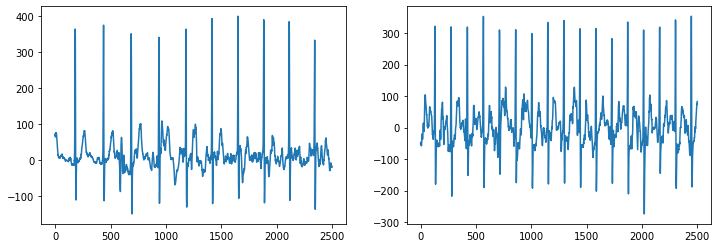

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(data[0][1])
plt.subplot(1,2,2)
plt.plot(data[20][1])
plt.show()